In [17]:
# import & set-up
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [18]:
# Transformasi: Normalisasi piksel ke [0,1]
transform = transforms.Compose([
    transforms.ToTensor()
])

# Download dan load MNIST
full_train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# DataLoader
train_size = int(0.9 * len(full_train_dataset))
val_size = len(full_train_dataset) - train_size
train_data, val_data = random_split(full_train_dataset, [train_size, val_size])

train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
val_loader = DataLoader(val_data, batch_size=1000, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=1000, shuffle=False)

print(f"Train set size: {len(train_dataset)}, Test set size: {len(test_dataset)}")

Train set size: 60000, Test set size: 10000


In [19]:
# LeNet Model
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2(x), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [20]:
# train, validation, test
def train(model, device, train_loader, optimizer, criterion, epoch):
    model.train()
    total_loss = 0
    for data, target in train_loader:
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(train_loader)

def validate(model, device, val_loader, criterion):
    model.eval()
    correct = 0
    loss = 0
    with torch.no_grad():
        for data, target in val_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            loss += criterion(output, target).item()
            pred = output.argmax(dim=1)
            correct += pred.eq(target).sum().item()
    return loss / len(val_loader), 100. * correct / len(val_loader.dataset)

def test(model, device, test_loader, criterion):
    model.eval()
    correct = 0
    loss = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            loss += criterion(output, target).item()
            pred = output.argmax(dim=1)
            correct += pred.eq(target).sum().item()
    return loss / len(test_loader), 100. * correct / len(test_loader.dataset)


In [21]:
# prunning
def prune_by_percentile(model, prune_percent, current_mask):
    all_weights = []
    for name, param in model.named_parameters():
        if name in current_mask:
            masked_weights = param.data[current_mask[name] == 1]
            all_weights += list(masked_weights.abs().cpu().detach().numpy())
    threshold = np.percentile(np.array(all_weights), prune_percent)

    new_mask = {}
    for name, param in model.named_parameters():
        if name in current_mask:
            new_mask[name] = (param.data.abs() > threshold).float() * current_mask[name]
    return new_mask

def apply_mask_and_reset(model, initial_weights, mask_dict):
    with torch.no_grad():
        for name, param in model.named_parameters():
            if name in mask_dict:
                param.copy_(initial_weights[name] * mask_dict[name])

In [22]:
# iterative prunning
def run_experiment(prune_percent=20, max_iterations=5, early_stop_patience=3):
    all_final_accuracies = []

    for trial in range(5):
        print(f"\n Trial {trial + 1}")
        model = LeNet().to(device)
        initial_weights = {k: v.clone() for k, v in model.state_dict().items()}
        current_mask = {k: torch.ones_like(v) for k, v in initial_weights.items() if 'weight' in k}

        for iteration in range(max_iterations):
            print(f"\n Iteration {iteration + 1}/{max_iterations}")
            model.load_state_dict(initial_weights)
            apply_mask_and_reset(model, initial_weights, current_mask)

            optimizer = optim.Adam(model.parameters(), lr=0.001)
            criterion = nn.CrossEntropyLoss()

            best_val_acc = 0
            patience = 0
            epoch = 0
            max_epoch = 50
            last_test_acc = 0

            while epoch < max_epoch and patience < early_stop_patience:
                train_loss = train(model, device, train_loader, optimizer, criterion, epoch)
                val_loss, val_acc = validate(model, device, val_loader, criterion)
                test_loss, test_acc = test(model, device, test_loader, criterion)

                if val_acc > best_val_acc:
                    best_val_acc = val_acc
                    patience = 0
                else:
                    patience += 1

                epoch += 1
                print(f"[Epoch {epoch}] Val Acc: {val_acc:.2f}%, Test Acc: {test_acc:.2f}%")
                last_test_acc = test_acc

            all_final_accuracies.append(last_test_acc)
            current_mask = prune_by_percentile(model, prune_percent, current_mask)

    mean_acc = np.mean(all_final_accuracies)
    std_acc = np.std(all_final_accuracies)
    print(f"\n Final Test Accuracy over {5 * max_iterations} runs: {mean_acc:.2f}% ± {std_acc:.2f}%")
    return all_final_accuracies


In [ ]:
result_accs = run_experiment(prune_percent=20, max_iterations=5, early_stop_patience=3)


 Trial 1

 Iteration 1/5


In [13]:
prune_percent = 20
mask_dict = prune_by_percentile(model, prune_percent)

In [14]:
def apply_mask_and_reset(model, initial_weights, mask_dict):
    """
    Terapkan mask ke bobot dan reset ke initial weights (hanya untuk bobot yang tidak dipruning)
    """
    with torch.no_grad():
        for name, param in model.named_parameters():
            if name in mask_dict:
                # Reset ke initial dan terapkan mask
                param.copy_(initial_weights[name] * mask_dict[name])


In [15]:
# Inisialisasi ulang model dan mask
model = LeNet().to(device)
apply_mask_and_reset(model, initial_state_dict, mask_dict)

# Optimizer baru
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training ulang model hasil pruning
retrain_accuracies = []

for epoch in range(1, EPOCHS + 1):
    train_loss = train(model, device, train_loader, optimizer, criterion, epoch)
    test_loss, test_acc = test(model, device, test_loader, criterion)
    retrain_accuracies.append(test_acc)
    print(f"[Pruned] Epoch {epoch}: Train Loss = {train_loss:.4f}, Test Accuracy = {test_acc:.2f}%")

[Pruned] Epoch 1: Train Loss = 0.2707, Test Accuracy = 97.32%
[Pruned] Epoch 2: Train Loss = 0.0808, Test Accuracy = 98.43%
[Pruned] Epoch 3: Train Loss = 0.0589, Test Accuracy = 98.39%
[Pruned] Epoch 4: Train Loss = 0.0459, Test Accuracy = 98.68%
[Pruned] Epoch 5: Train Loss = 0.0377, Test Accuracy = 98.50%
[Pruned] Epoch 6: Train Loss = 0.0316, Test Accuracy = 98.84%
[Pruned] Epoch 7: Train Loss = 0.0267, Test Accuracy = 99.04%
[Pruned] Epoch 8: Train Loss = 0.0230, Test Accuracy = 98.91%
[Pruned] Epoch 9: Train Loss = 0.0201, Test Accuracy = 99.24%
[Pruned] Epoch 10: Train Loss = 0.0179, Test Accuracy = 98.98%
[Pruned] Epoch 11: Train Loss = 0.0154, Test Accuracy = 99.00%
[Pruned] Epoch 12: Train Loss = 0.0144, Test Accuracy = 99.07%
[Pruned] Epoch 13: Train Loss = 0.0136, Test Accuracy = 99.03%
[Pruned] Epoch 14: Train Loss = 0.0099, Test Accuracy = 99.01%
[Pruned] Epoch 15: Train Loss = 0.0105, Test Accuracy = 99.03%
[Pruned] Epoch 16: Train Loss = 0.0086, Test Accuracy = 98.84%
[

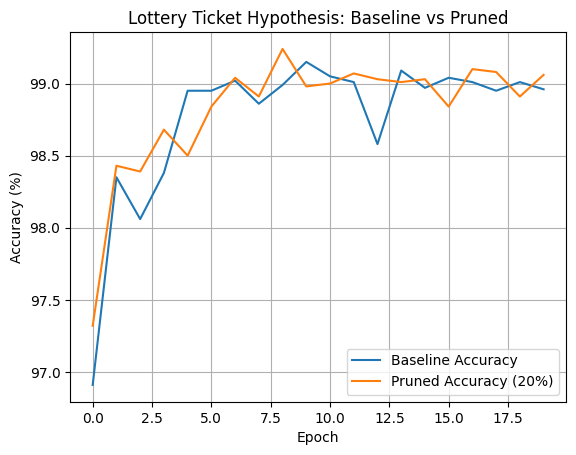

In [16]:
plt.plot(test_accuracies, label='Baseline Accuracy')
plt.plot(retrain_accuracies, label=f'Pruned Accuracy ({prune_percent}%)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Lottery Ticket Hypothesis: Baseline vs Pruned')
plt.legend()
plt.grid(True)
plt.show()
